# Machine Learning: Aula 3

Nessa prática iremos abordar como implementar um classificador baseado no conceito de regressão logística, no dataset Pap-Smear do Herlev Hospital, estudado por [1].

O dataset pode ser baixado [neste link](http://mde-lab.aegean.gr/index.php/downloads)

In [1]:
import torch
import shutil
import numpy as np
import pandas as pd
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt

## Probabilidade

Probabilidade é uma área da matemática dedicada ao estudo da incerteza. Primeiro, vamos caracterizar matematicamente esse conceito. Suponha que você tem a função

$$x = \sin(t)$$

note que, para um dado valor de $t$, o valor de $x$ pode ser unicamente determinado. 

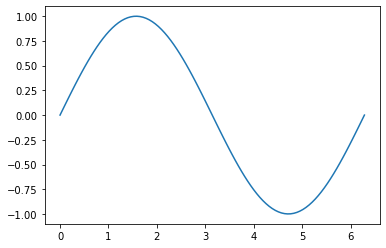

In [2]:
t = np.linspace(0, 2 * np.pi, 100)
x = np.sin(t)
plt.plot(t, x)

nesse caso, dizemos que a relação entre as variáveis $t$ e $x$ é __determinística__. Por outro lado, algumas vezes nós não temos uma relação $x(t)$ explicitamente, mas dados $(t_{i}, x_{i})$ que refletem uma incerteza na relação entre $t$ e $x$,

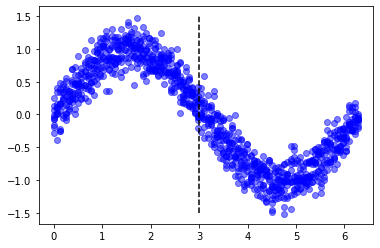

In [3]:
for i in range(10):
    t = np.linspace(0, 2 * np.pi, 100)
    x = np.sin(t) + .2 * np.random.randn(*t.shape)
    plt.scatter(t, x, c='b', alpha=0.5)
plt.plot([3, 3], [-1.5, 1.5], 'k--')

Em geral situações como essa aparecem quando colhemos dados empiricamente. Sobretudo devido a ruídos característicos dos aparelhos de medição, assumimos que existe um ruído $\epsilon$. No caso anterior, temos,

$$x(t) = sin(t) + \epsilon$$

for $\epsilon \sim \mathcal{N}(0, 0.2)$. O símbolo $\sim$ significa "distribuído de acordo com" e $\mathcal{N}$ denota a distribuição de probabilidade de $\epsilon$. Na discussão que se segue, isso ficará mais claro.

### Definição Axiomática

Na nossa discussão, iremos seguir a exposição introdutória de [2]

__Definição 1:__ O conjunto $\Omega$ contendo todos os possíveis resultados de um experimento é chamado de espaço amostral (sample space).

Para contextualizar, podemos considerar o exemplo de se jogar uma moeda. O experimento, no caso, é o ato de se jogar a moeda. Os resultados correspondem à cara ($CA$) e coroa ($CO$). Portanto,

$$\Omega = \{CA, CO\}$$

ou seja, temos apenas dois eventos no espaço amostral.

No exemplo anterior, em que temos uma relação funcional entre $t$ e $x$, corrompida por um ruído de medição, note que $x$ toma valores nos números reais. O experimento corresponde a medir $x$ no instante $t$. Portanto temos como espaço amostral $\Omega = \mathbb{R}$. Nesse caso, temos um espaço amostral __incontável__, ao contrário do caso da moeda, em que tínhamos um espaço amostral __contável__ (com dois elementos).

__Definição 2:__ Um evento é qualquer coleção de possíveis resultados de um experimento, ou seja, qualquer sub-conjunto de $\Omega$.

Portanto, a teoria de probabilidade busca tratar de probabilidades de __eventos__, ao invés de resultados. Note que, nesse sentido, o conjunto que contém __todos os sub-conjuntos__ de $\Omega$ será útil. Esse conjunto é chamado de __conjunto das partes__ (em inglês, _powerset_). Para o caso do lançamento de uma moeda, temos,

$$\mathcal{P}(\Omega) = \{\emptyset, \{CA\}, \{CO\}, \{CA,CO\}\}$$

Para o caso de $x(t) = sin(t) + \epsilon$, $\mathcal{P}(\mathbb{R}^{d})$ é o conjunto de todos os intervalos na reta dos números reais.

De modo geral, temos a seguinte definição,

__Definição 3:__ Seja $\Omega$ um conjunto. Uma coleção de sub-conjuntos de $\Omega$ é uma $\sigma-$álgebra, denotada por $\mathcal{F}$, se satisfaz as seguintes propriedades,

1. $\emptyset \in \mathcal{F}$
2. $A \in \mathcal{F} \implies A^{c} \in \mathcal{F}$
3. $A_{1},A_{2},\cdots \in \mathcal{F} \implies \cup_{i=1}^{\infty}A_{i} \in \mathcal{F}$  

Note que, em especial, $\mathcal{P}(\Omega)$ é uma $\sigma-$Álgebra. De modo geral, $(\Omega, \mathcal{F})$ é chamado de __espaço de medida__. Podemos agora definir o que é uma função de probabilidade.

__Definiãção 4:__ Seja $\Omega$ um conjunto, e $\mathcal{F}$ uma $\sigma-$Álgebra. Uma medida de probabilidade é uma função $P:\mathcal{F}\rightarrow [0, 1]$ se satisfaz as seguintes propriedades,

1. $P(A) \geq 0, \forall A \in \mathcal{F}$,
2. $P(\Omega) = 1$
3. $P(\cup_{i=1}^{\infty}A_{i}) = \sum_{i=1}^{\infty}p(A_{i})$, if $A_{i} \cap A_{j} = \emptyset$.

A tripla $(\Omega, \mathcal{F}, P)$ é chamado de espaço de probabilidade.


#### Probabilidades em conjuntos discretos

Dizemos que um conjunto é discreto quando $\Omega = \{s_{1}, s_{2}, \cdots, s_{n}\}$. Note que, no caso cara-ou-coroa temos $n = 2$, com $s_{1} = CA$ e $s_{2} = CO$. No caso geral, seja $\mathcal{F}$ qualquer $\sigma-$Álgebra em $\Omega$. Definimos,

$$P(A) = \sum_{\{i:s_{i} \in A\}}p_{i}$$

onde $p_{i} \geq 0$ para $i=1,\cdots, n$ são números reais, tais que

$$\sum_{i=1}^{n}p_{i} = 1$$

normalmente associamos cada $p_{i}$ com a amostra correspondente $s_{i}$. Note que podemos denotar $\mathbf{p} = [p_{1}, p_{2}, \cdots, p_{n}] \in \mathbb{R}^{n}_{+}$ ao vetor com as probabilidades de cada amostra. Chamamos o conjunto

$$\Delta_{n} = \{\mathbf{p} \in \mathbb{R}^{n}_{+}:\sum_{i=1}^{n}p_{i} = 1\}$$

de "simplex de probabilidade" de dimensão $n$.

#### Probabilidades em conjuntos contínuos

Dizemos que um conjunto é contínuo quando para cada $x_{0} \in \Omega$, tem-se

$$\lVert x - x_{0} \rVert < \delta \implies x \in \Omega$$

para qualquer $\delta > 0$. De modo intuitivo, a ideia é que podemos dar um zoom infinito na vizinhança de $x_{0}$, sem sair do conjunto $\Omega$. Nesse caso, não faz sentido somarmos os elementos $s_{i} \in A$, pois $A$ pode ter um número __incontável__ de elementos. Tampouco faz sentido atribuir um valor $p_{i}$ para cada $s_{i}$, pois $\Omega$ também é incontável.

A ideia, no caso, é definir uma função $f(x)$ que atribui a __densidade de probabilidade__ de um elemento $x \in A$. Dessa forma, podemos calcular a probabilidade de um conjunto $A \subset \Omega$ da seguinte forma,

$$P(A) = \int_{A}f(x)dx.$$

Note que $f(x)$ deve satisfazer a seguinte propriedade,

$$P(\Omega) = \int_{\Omega}f(x)dx = 1.$$

__Nota:__ Caso $\Omega$ seja contínuo, $f$ é dita função densidade de probabilidade atrelada à medida de probabilidade $\mu$. Caso $\Omega$ seja discreto, o vetor $\mathbf{p} \in \Delta_{n}$ é a ideia correspondente de densidade de probabilidade, normalmente dito histograma. Note que quando $\Omega$ é discreto, faz sentido a notação,

$$P(x_{i}) = p_{i}.$$

#### Probabilidade Condicional

__Definição 5:__ Para eventos $A$ e $B$ em $\Omega$, a probabilidade condicional de $A$ dado $B$ é,

$$P(A|B) = \dfrac{P(A\cap B)}{P(B)}$$

A intuição para a probabilidade condicional é a seguinte: queremos calcular a probabilidade de um evento A, dado que B aconteceu. A ocorrência de $B$ atualiza, de alguma forma, a ocorrência dos eventos $A \in \mathcal{F}$.

__Caso 1:__ Se $A$ e $B$ são __disjuntos__, tem-se $P(A \cap B) = 0$. Dessa forma $P(A|B) = P(B|A) = 0$.

__Caso 2:__ Note que $P(A \cap B) = P(B \cap A)$. Assim podemos derivar a regra de Bayes,

$$P(A|B) = \dfrac{P(B|A)P(A)}{P(B)}$$

#### Exercício

Quando $A$ e $B$ são independentes, tem-se que $P(A|B) = P(A)$ e $P(B|A) = P(B)$. A partir disso, temos,

$$P(A\cap B) = P(A|B)P(B) = P(A)P(B)$$

__OBS:__ Em alguns casos $P(A \cap B)$ é expresso como $P(A, B)$, ou seja, $P$ é interpretada como uma função de dois conjuntos $A$ e $B$. Note que, com essa notação, tem-se,

$$P(A, B) = P(A)P(B)$$

### Variáveis Aleatória

Em alguns casos, quando lidamos com espaços amostrais $\Omega$ qualitativos (não-numéricos), calcular probabilidades e estatísticas pode não ser tão intuitivo.

Por exemplo, [2] considera o seguinte caso: suponha que você está coletando opiniões, cuja resposta é "concordo" (1), ou "discordo" (0) de 50 pessoas. Isso nos dá um espaço amostral de $2^{50}$ elementos, correspondendo a todas as possíveis combinações de "concordo" e "discordo". Suponha que nós só estamos interessados no número de pessoas que concordam (ou discordam) com a pergunta da pesquisa. Nesse caso, é mais simples de trabalhar com $X = \#\text{pessoas que concordam}$. Nesse caso, $\Omega$ é reduzido para os inteiros $\Omega = \{1, 2, \cdots, 50\}$. Esse método é o princípio por detrás do conceito de __variável aleatória__.

__Definição 6:__ Uma variável aleatória $X:\Omega\rightarrow\mathbb{R}$ é uma função que mapeia cada amostra em $\omega \in \Omega$ para um número real $X(\omega)$.

Note que podemos extender essa ideia para um __vetor aleatório__, que é uma função vetorial $X:\Omega\rightarrow\mathbb{R}^{d}$.

Em geral, quando $X$ segue uma distribuição de probabilidade $f$, ou quando $\mu$ é a regra que atribui probabilidades a eventos $X(A)$, $A \in \mathcal{F}$, diz-se que $X\sim f$ ou $X \sim P$.

### Valor Esperado e Estatísticas

O valor esperado de uma variável aleatória está relacionado a noção de "média". Nesse caso, note que como cada amostra tem uma importância, ou probabilidade diferente, essa média é ponderada pela densidade $f(x)$, ou pelos valores $p_{i}$ atrelados a cada $x_{i}$.

__Definição 7:__ Seja $\Omega$ um espaço amostral e $X:\Omega\rightarrow\mathbb{R}^{d}$ um vetor aleatório, de modo que $X \sim \mu$. A esperança de $X$ é dada por,

$$\underset{\mathbf{x} \sim P}{\mathbb{E}}[ \mathbf{x} ] = \begin{cases}
\int_{\Omega}\mathbf{x}f(\mathbf{x})d\mathbf{x} & \text{se } \Omega \text{ é contínuo},\\
\sum_{i=1}^{n}p_{i}\mathbf{x}_{i} & \text{se } \Omega \text{ é discreto}.
\end{cases}$$



### Famílias de Distribuições

Seja $\Omega = \mathbb{R}^{d}$ um espaço amostral. Dizemos que $S$ é uma família de distribuições quando os elementos $f \in S$ são densidades de probabilidade. Denotamos por $P(\Omega)$ o conjunto de todas as distribuições sobre o espaço amostral $\Omega$.

Dizemos que $S$ é parametrizada por parâmetros $\theta \in \mathbb{R}^{n}$ quando,

$$S = \{f \in P(\Omega): f = f(\cdot;\theta)\}$$

A partir de agora iremos abordar famílias de distribuições, tanto discretas como contínuas.



#### Distribuições Discretas

A partir de agora, suponha que $\Omega = \{\omega_{1}, \omega_{2}, \cdots, \omega_{N}\}$ é composto por $N$ pontos num intervalo $[a, b]$.

##### Distribuição Uniforme

Dizemos que $P$ é uniforme quando $P(x_{i}) = p$ fixo. Note que, a partir dessa informação, podemos derivar o valor de $p$, já que,

$$P(\Omega) = 1 = \sum_{i=1}^{N}P(x_{i}) = \sum_{i=1}^{N}p = Np$$

portanto $p = 1/N$. Para ilustrar essa família de distribuições, considere uma distribuição uniforme sobre $N = 11$ pontos, no intervalo $[0, 1]$.

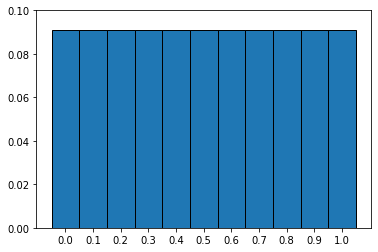

In [4]:
N = 11
p = 1 / N
x = np.linspace(0, 1, N)
P = np.array([p for _ in range(N)])

plt.bar(x, P, width=x[1] - x[0], edgecolor='k')
_ = plt.xticks(x)
_ = plt.yticks([0.02 * i for i in range(6)])

In [6]:
P

array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

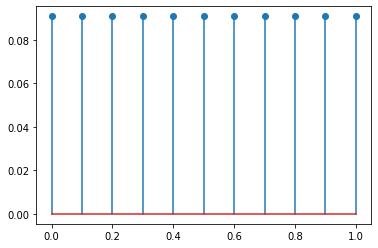

In [5]:
plt.stem(x, P)

#### Distribuição de Bernoulli

Voltemos para o problema "cara ou coroa". Considere a variável aleatória $X(CA) = 1$, $X(CO) = 0$. A moeda é dita "justa", se $P(X=1) = P(X=0) = 0.5$. Agora, imagine que o experimento não é justo, ou seja, $P(X = 1) \neq P(X = 0)$. Nesse caso, suponha $P(X = 1) = p$. Tem-se imediatamente $P(X = 0) = 1 - P(X = 1) = 1 - p$.

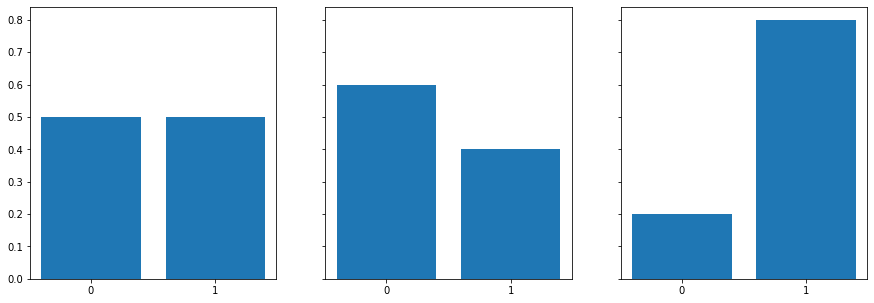

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

x = [0, 1]
P = [0.5, 0.5]
axes[0].bar(x, P)
axes[0].set_xticks(x)

x = [0, 1]
P = [0.6, 0.4]
axes[1].bar(x, P)
axes[1].set_xticks(x)

x = [0, 1]
P = [0.2, 0.8]
axes[2].bar(x, P)
axes[2].set_xticks(x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a s

<StemContainer object of 3 artists>

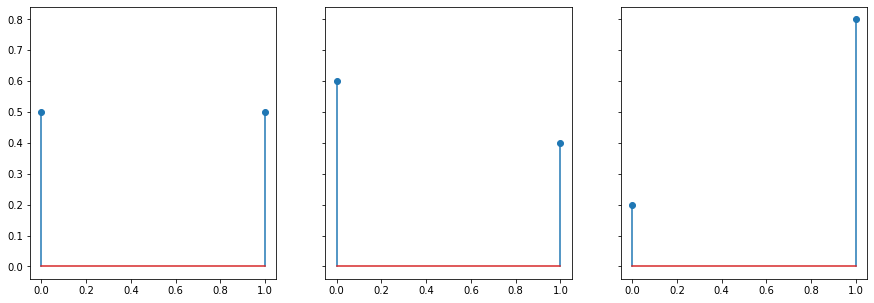

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

x = [0, 1]
P = [0.5, 0.5]
axes[0].stem(x, P)

x = [0, 1]
P = [0.6, 0.4]
axes[1].stem(x, P)

x = [0, 1]
P = [0.2, 0.8]
axes[2].stem(x, P)

## Regressão Logística

O algoritmo chamado de Regressão Logística corresponde a supor um __modelo probabilístico__ para as predições, através das distribuições,

$$P(Y|X)$$

onde $Y$ é uma variável aleatória correspondendo às classes, e $X$ às características. Por exemplo, num caso de classificação binária, tem-se,

$$P(Y=1|X=\mathbf{x})$$

que corresponde à probabilidade de ter-se $y = 1$ dado que se observou $\mathbf{x}$. Note que como $y = 1$ ou $y = 0$, podemos supor $P(Y=1|X) = p$ e $P(Y=0|X) = 1 - p$ de tal forma que

$$P(Y=1|X) + P(Y=0|X) = p + (1 - p) = 1.$$

Note que, de modo geral, tem-se,

$$P(Y|X) = p^{y}(1-p)^{1-y}$$

$$P(Y=1|X) = p^{1}(1-p)^{1-1} = p$$

$$P(Y=0|X) = p^{0}(1-p)^{1-0} = 1-p$$

Assumimos então um modelo linear para o chamado "logit", que é dado por,

$$\text{logit}\,p = \log\dfrac{p}{1-p} = \log\dfrac{P(Y=1|X)}{P(Y=0|X)}$$

Note que usando o logit, temos o seguinte,

$$P(Y=1|X) > P(Y=0) \implies \dfrac{P(Y=1|X)}{P(Y=0|X)} > 1 \implies \text{logit}\, p > 0$$

$$P(Y=1|X) < P(Y=0) \implies \dfrac{P(Y=1|X)}{P(Y=0|X)} < 1 \implies \text{logit}\, p < 0$$

podemos então modelar o logit através de uma função linear,

$$\text{logit}\, p = \theta^{T}\mathbf{x}+b$$

note que podemos expressar $p$ da seguinte forma,

$$p = \dfrac{1}{1+e^{-\theta^{T}\mathbf{x}-b}} = \sigma(\mathbf{x})$$

onde $\sigma$ é a chamada __função sigmóide__.

#### Questão

Mostre que se $\text{logit}\, p = \theta^{T}\mathbf{x} + b$, então

$$ p = \sigma(\mathbf{x})$$

### Máxima Verossimilhança

Dado o modelo probabilístico, como podemos estimar $\theta$ e $b$? A ideia é fazer uma __estimação de máxima verossimilhança__.

A ideia dessa técnica é a seguinte: suponha que temos dois pares de parâmetros, $(\theta_{1}, b_{1})$ e $(\theta_{2}, b_{2})$, precisamos de uma função $\mathcal{L}$ que vai nos dizer o quão bom os parâmetros se ajustam às probabilidades. No caso 

$$\mathcal{L}(\theta, b) = P(y_{1}, \cdots, y_{N}|\mathbf{x}_{1},\cdots,\mathbf{x}_{N})$$

é a probabilidade conjunta de __todo o dataset__. Assumimos então que cada amostra $\{\mathbf{x}_{i}, y_{i}\}$ é independente e igualmente distribuída (de acordo com $P(Y|X)$), então,

$$\mathcal{L}(\theta, b) = \prod_{i=1}^{N}P(Y=y_{i}|X=\mathbf{x}_{i})$$

ou seja,

$$\mathcal{L}(\theta, b) = \prod_{i=1}^{N}p^{y_{i}}(1-p)^{1-y_{i}}$$
$$\mathcal{L}(\theta, b) = \prod_{i=1}^{N}\sigma(\mathbf{x}_{i})^{y_{i}}(1-\sigma(\mathbf{x}_{i}))^{1-y_{i}}$$

Note que essa função é difícil de ser otimizada (como calcular os gradientes?). Utilizamos então o log da máxima verossimilhança,

$$\log\,\mathcal{L}(\theta,b) = \sum_{i=1}^{N}y_{i}\log\sigma(\mathbf{x}_{i})+(1-y_{i})\log(1-\sigma(\mathbf{x}_{i}))$$

Definimos então,

$$L(\theta, b) = \dfrac{1}{N}\mathcal{L}(\theta, b)$$

### Otimização

Queremos maximizar $L(\theta, b)$ com respeito a $\theta$ e a $b$. Para tanto, precisamos calcular os gradientes. Na próxima questão vocês serão desafiados a calcular os gradients de $L$.



#### Questão 1

Mostre que

$$\dfrac{\partial L}{\partial \theta} = \dfrac{1}{N}\sum_{i=1}^{N}(y_{i} - \sigma(\mathbf{x}_{i}))\mathbf{x}_{i}$$

$$\dfrac{\partial L}{\partial b} = \dfrac{1}{N}\sum_{i=1}^{N}y_{i} - \sigma(\mathbf{x}_{i})$$

### Gradiente Ascendente/Descendente

Note que a equação

$$\dfrac{\partial L}{\partial \theta} = \dfrac{1}{N}\sum_{i=1}^{N}(y_{i} - \sigma(\mathbf{x}_{i}))\mathbf{x}_{i} = 0$$

não tem solução analítica. O que nós precisamos, então, é utilizar um algoritmo conhecido como gradiente descendente (minimização)/ascendente (maximização).

A ideia é que o vetor gradiente $\nabla L$ (resp. $-\nabla L$) dá a direção de máximo aumento (resp. redução) da função $L$. Assim, podemos inicializar $\theta^{0} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$ e $b^{0} \sim \mathcal{N}(0, 1)$, de tal forma que,

$$\theta^{k+1} = \theta^{k} + \eta\dfrac{\partial \mathcal{L}}{\partial \theta} = \theta^{k} + \eta\dfrac{1}{N}\sum_{i=1}^{N}(y_{i}-\sigma(\mathbf{x}_{i}))\mathbf{x}_{i}$$
$$b^{k+1} = b^{k} + \eta\dfrac{\partial \mathcal{L}}{\partial b} = b^{k} + \eta\dfrac{1}{N}\sum_{i=1}^{N}y_{i}-\sigma(\mathbf{x}_{i})$$

isso nos dá um __algoritmo interativo__ para atualizar os parâmetros $\theta$ e $b$ até alcançar as soluções $\theta^{\star}$ e $b^{\star}$. 

## Live Coding 1: Regressão Logística Binomial

## Regressão Logística Multinomial

Como anteriormente, suponhamos que $y$ não é mais uma variável binária (classe positiva/negativa), mas uma entre $K$ classes. Como vimos anteriormente, transformamos $y = k$ num vetor $\mathbf{t}$, com $1$ na posição $k$, e $0$ nas demais. Relembrando, para $K = 6$ e $k = 3$, tem-se,

$$y = 6 \implies \mathbf{t} = (0, 0, 1, 0, 0, 0)^{T}.$$

Note que podemos utilizar o mesmo modelo probabilístico da regressão logística comum, com pequenas mudanças:

$$P(T|X) = \prod_{k=1}^{K}p_{k}^{t_{k}}.$$

Note que agora temos $k$ probabilidades, ou um vetor $\mathbf{p} = (p_{1},\cdots,p_{K})^{T}$ em que

$$p_{k} = P(Y=k|X)$$

como $p$ é uma distribuição (discreta) de probabilidades, temos,

$$\sum_{k=1}^{K}p_{k} = 1$$

ou...

$$\mathbf{p}^{T}\mathbf{1}_{K} = 1$$

De forma um pouco diferente da regressão logística binomial, iremos assumir um modelo logarítmico para $p_{k}$,

$$\log p_{k} = \theta^{T}_{k}\mathbf{x} + b_{k} - \log Z$$
$$p_{k} = \dfrac{1}{Z}e^{\theta_{k}\mathbf{x}+b_{k}}$$

onde $Z$ é uma constante à determinar para que $\sum_{k=1}^{K}p_{k} = 1$, ou seja,

$$\sum_{k=1}^{K}p_{k} = \sum_{k=1}^{K}\dfrac{1}{Z}e^{\theta_{k}\mathbf{x}+b_{k}}= \dfrac{1}{Z}\sum_{k=1}^{K}e^{\theta_{k}^{T}\mathbf{x}+b_{k}} = 1 \implies Z = \sum_{k=1}^{K}e^{\theta_{k}^{T}\mathbf{x}+b_{k}}$$

assim,

$$p_{k} = \dfrac{e^{\theta_{k}^{T}\mathbf{x}}+b}{\sum_{k=1}^{K}e^{\theta_{k}^{T}\mathbf{x}}+b}$$

a função acima é conhecida como __softmax__. Existe uma outra formulação que leva em conta logits, mas esta não é apresentada pois a função __softmax__ é usada de forma ubíqua em redes neurais. Maiores detalhes podem ser encontrados [nesse artigo na wikipedia](https://en.wikipedia.org/wiki/Multinomial_logistic_regression)

### Máxima Verossimilhança

Assim como para a regressão logística binomial, temos a seguinte expressão para a máxima verossimilhança do modelo da regressão logística,

$$\mathcal{L}(\theta, b) = \prod_{i=1}^{N}P(T=\mathbf{t}_{i}|X=\mathbf{x}_{i})$$
$$\mathcal{L}(\theta, b) = \prod_{i=1}^{N}\prod_{k=1}^{K}p_{ik}^{t_{ik}}$$

de novo, definindo,

$$L(\theta, b) = \dfrac{1}{N}\log \mathcal{L}(\theta, b)$$

e definindo a função de custo "entropia cruzada",

$$CE(\mathbf{t}_{i},\mathbf{p}_{i})=\sum_{k=1}^{K}t_{ik}\log p_{ik}$$

temos,

$$L(\theta, b) = \dfrac{1}{N}\sum_{i=1}^{N}CE(\mathbf{t}_{i},\mathbf{p}_{i})$$

## Live Coding 2: Regressão Logística Multinomial

## Referências

[1] Marinakis, Y., Dounias, G., & Jantzen, J. (2009). Pap smear diagnosis using a hybrid intelligent scheme focusing on genetic algorithm based feature selection and nearest neighbor classification. Computers in Biology and Medicine, 39(1), 69-78.

[2] Casella, G., & Berger, R. L. (2021). Statistical inference. Cengage Learning.